# Ejemplo del Frozen Lake con Q-Learning

![CITIC](https://inil.ucr.ac.cr/wp-content/uploads/2023/06/CITIC.jpg)

Realizado por:
- Luis David Solano Santamaría

## Contexto

<p align = "justify">
¡En este ejercicio vamos a entrenar un agente para resolver el problema de Frozen Lake! Para esto, vamos a utilizar Q-Learning aprendiendo con experiencia más directa cómo funciona.
</p>

<p align="justify">
Vamos a utilizar una biblioteca popular de OpenAI, llamada Gymnasium. Esta nos da acceso a un API, que es una interfaz común para trabajar con ambientes de manera estándar sin tener que pensar nosotros en lo complicado de programar uno. En caso de querer consultar la documentación del problema, pueden dar click
<a href="https://gymnasium.farama.org/environments/toy_text/frozen_lake/" target="_blank">aquí</a>,
pero la idea es poder explicar en su enteridad el problema dentro de este mismo notebook.
</p>


### Problema a resolver

![Frozen Lake GIF](https://gymnasium.farama.org/_images/frozen_lake.gif)

<p align="justify">
Como elfos del CITIC debemos salvar la navidad del centro y recoger un regalo que se perdió en un lago congelado, ¡pero hay que caminar con cuidado ya que hay peligrosos huecos en los que podemos caer! Para esto vamos a crear un agente inteligente con aprendizaje por refuerzo, que va a aprender a navegar sobre este ambiente congelado para poder recoger el regalo y traerlo de vuelta.
</p>

<p align="justify">
Para entender entonces este problema debemos comprender lo siguiente:
</p>

- Espacio de acción
- Espacio de observación
- Estado inicial
- Recompensa


#### Espacio de acción

<p align="justify">
Para resolver esta tarea, nuestro agente posee un espacio de acción discreto que permite delimitar lo que podemos hacer. En esta tarea, nos vamos a poder a mover hacia: la izquierda, derecha, abajo y arriba. Para trabajar con una representación más amigable a la máquina vamos a traducir cada una de estas acciones a números del 0 al 3 de la siguiente manera:
</p>

0. Representa moverse a la **izquierda**

1. Representa moverse hacia **abajo**

2. Representa moverse a la **derecha**

3. Representa moverse hacia **arriba**


#### Espacio de observación

<p align="justify">
Ya sabemos de qué manera podemos actuar, ¿pero qué es lo que observamos en este ambiente? En este caso el espacio de observación es un único valor, la posición actual del jugador representada como un solo número. Para representar una posición en una matriz en un solo número podemos usar la siguiente ecuación:
</p>

$\text{position} = \text{current_row} \times \text{ncols} + \text{current_col}$

Donde se debe notar que la fila y columna empieza a contar desde 0.


#### Espacio inicial

<p align="justify">
Ahora que comprendemos nuestro estado, ¿dónde empieza nuestro elfo del CITIC a viajar? Siempre vamos a empezar en la posición 0, que corresponde a la fila 0 y columna 0 o en otras palabras la esquina superior izquierda. Vamos a querer viajar desde este punto a la esquina inferior derecha, donde perdimos el regalo.
</p>

#### Recompensa

<p align="justify">
Entendemos ya nuestra observación y parece describir todo lo que ocupamos, ahora solo nos falta entender nuestra recompensa para terminar de modelar el problema. Podríamos decir que esta se ve de la siguiente manera:
</p>

- Llegar al regalo nos da recompensa de +1
- Llegar a un hueco termina la ejecución y nos da recompensa de +0
- Congelarnos y nunca llegar nos da recompensa de +0

<p align="justify">
Ahora, esta es la definición estándar del ambiente, pero vamos a ajustarla un poquito para representar mejor la tarea que queremos. Entonces se va a ver de la siguiente manera:
</p>

- Por cada paso vamos a reducir -0.01, buscando que tome rutas cortas.
- Si llega al regalo lo vamos a compensar mucho mejor, dando +10
- Si se cae en un hueco queremos penalizar de manera fuerte, dando -5

### Q-Learning

#### Episodios

<p align="justify">
Vamos a entrenar a nuestro agente con un concepto que se llama episodio. Un episodio nos permite explorar el ambiente hasta que ciertas condiciones se cumplan y vamos a hacer cierta cantidad de estos para nuestro entrenamiento. Las condiciones que tenemos para este problema son:
</p>

Si llegamos a un estado de **terminación** solo es posible si nuestro agente:

1. Terminó en alguno de los huecos y murió :(
2. Llegamos al objetivo y recuperamos el regalo del CITIC :)

¡Pero queremos ser rápidos, si duramos demasiado vamos a ser truncados! Por lo que si hacemos más de 200 movimientos vamos a ser truncados y el episodio va a terminar.

#### Dilema del Q-Table

Para hacer el problema un poco más interesante que el GIF, vamos a trabajar en un lago de tamaño de $8 \times 8$

¿Cómo sería nuestro Q-Table entonces?

¿Cómo está compuesto?

De ser posible me gustaría que piensen un poco esto, pero abajo va a estar la respuesta :)

#### Respuesta del Q-Table

No me sorprende si alguno por adelantado termina leyendo la respuesta antes sin querer, ¡sería yo fácilmente!

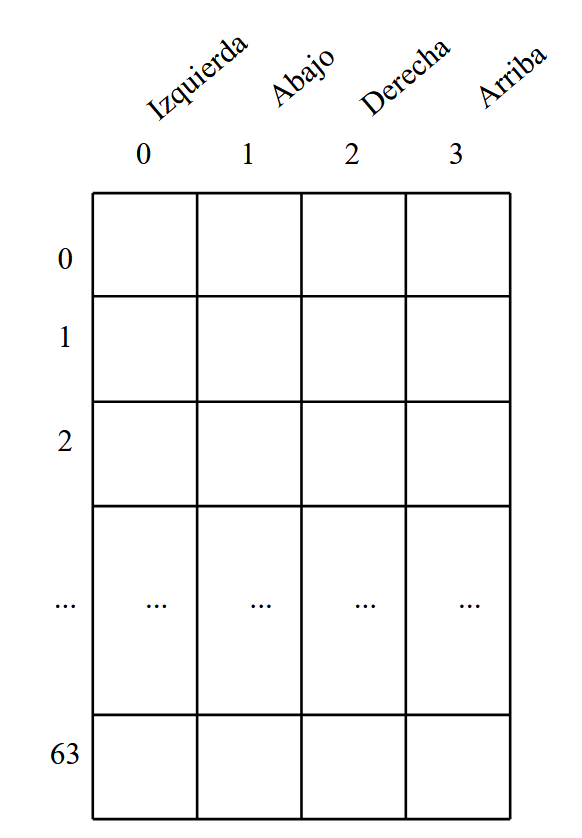

Recordemos entonces que nuestras columnas son nuestras acciones, del 0 al 3 según lo discutido previamente, y tenemos $64$ estados, que van desde el 0 hasta el 63, dando la tabla anterior.

#### Behavior Policy

Vamos a utilizar como política de comportamiento un algoritmo conocido como `Epsilon-Greedy Algorithm`.

Este nos va a permitir atacar directamente el problema de exploración y explotación, balanceando entre decisiones aleatorias para rellenar la política y luego decisiones informadas entre más se encuentra llena.

Si quieren darle una lectura pueden hacerlo [aquí](https://www.google.com/search?client=firefox-b-d&q=epsilon+greedy+selection), ya que es importante y útil aunque no fuera cubierto.

## Ejecución

### Dependencias

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Funciones auxiliares

In [ ]:
import numpy as np
import gymnasium as gym

def train_q_learning(env, num_episodes=10000, learning_rate=0.05, gamma=0.99,
                     epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.01):
    state_size = env.observation_space.n
    action_size = env.action_space.n
    Q_table = np.zeros((state_size, action_size))

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                # Choose to explore
                action = env.action_space.sample()
            else:
                # Prefer the Q Table, exploit
                action = np.argmax(Q_table[state, :])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if not done:
                # Small penalty for every step
                reward = -0.01
            if terminated and reward == 1.0:
                # Large reward for reaching goal
                reward = 10
            elif terminated and reward == 0.0:
                # Large penalty for falling into a hole
                reward = -5

            # Q-learning update
            Q_table[state, action] = (1 - learning_rate) * Q_table[state, action] + \
                                     learning_rate * (reward + gamma * np.max(Q_table[next_state, :]))

            state = next_state

        # Reduce exploration over time
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}/{num_episodes} - Epsilon: {epsilon:.4f}")

    return Q_table

def evaluate_agent(env, Q_table, num_episodes=100):
    total_rewards = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            # Choose best action
            action = np.argmax(Q_table[state, :])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_rewards += reward

    print(f"Average success rate over {num_episodes} episodes: {total_rewards / num_episodes:.2f}")

def run():
  env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
  Q_table = train_q_learning(env)
  evaluate_agent(env, Q_table)
  return Q_table


### Entrenamiento del modelo

In [ ]:
Q_table = run()

## Video de resultado

### Dependencias

In [ ]:
import os
import base64
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML, display

### Generación de video

In [ ]:


def record_video(env, Q_table, video_folder="videos", num_episodes=1):
    os.makedirs(video_folder, exist_ok=True)
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = np.argmax(Q_table[state, :])  # Choose best action
            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

    env.close()

def show_video(video_folder="videos"):
    video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(".mp4")])
    if not video_files:
        print("No video found in folder.")
        return

    video_path = os.path.join(video_folder, video_files[-1])
    with open(video_path, "rb") as video_file:
        video_base64 = base64.b64encode(video_file.read()).decode()
    display(HTML(f'<video width="600" controls><source src="data:video/mp4;base64,{video_base64}" type="video/mp4"></video>'))

def download_video(video_folder="videos"):
    video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(".mp4")])
    if not video_files:
        print("No video found to download.")
        return

    video_path = os.path.join(video_folder, video_files[-1])
    from google.colab import files
    files.download(video_path)


video_folder = "videos"
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="rgb_array")
record_video(env, Q_table, video_folder=video_folder)

show_video(video_folder)
download_video(video_folder)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>